In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm

!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

from ucimlrepo import fetch_ucirepo 

from IPython.display import clear_output

import keras
import logging
import os
from itertools import product

logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

clear_output()

std_plot_size = (6.4, 4.8)
curr_seed = 5636072
test_perc = 0.4
num_exp = 30

plots_dir = 'plots'
tables_dir = 'tables'

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
    
if not os.path.exists(tables_dir):
    os.makedirs(tables_dir)

In [2]:
def save_table_to_tex(df, file_name, fix_r2_col_names=True, column_format=None):
    # Replace R2 with proper LaTeX formatting
    out_df = df.replace('R2', '$R^2$')
    if fix_r2_col_names:
        out_df.columns = [col.replace('R2', '$R^2$') for col in out_df.columns]
    
    # Set default column format if not provided, ensuring all columns have vertical lines
    if column_format is None:
        column_format = '|l|' + 'c|' * (len(out_df.columns) - 1)
    
    with open(os.path.join(tables_dir, f'{file_name}.tex'), 'w') as tf:
        # Start table environment with full borders
        tf.write(r'\begin{table}[ht]' + '\n')
        tf.write(r'\centering' + '\n')
        tf.write(r'\begin{tabular}{' + column_format + '}' + '\n')
        tf.write(r'\hline' + '\n')  # Top horizontal line
        
        # Write the column headers manually with \hline
        tf.write(' & '.join(out_df.columns) + r' \\' + '\n')
        tf.write(r'\hline' + '\n')  # Horizontal line after header
        
        # Write table rows and ensure \hline after each row
        for row in out_df.itertuples(index=False, name=None):
            tf.write(' & '.join([str(item) for item in row]) + r' \\' + '\n')
            tf.write(r'\hline' + '\n')  # Horizontal line after each row
        
        tf.write(r'\end{tabular}' + '\n')
        
        # Add caption and label
        tf.write(r'\caption{Your Caption Here}' + '\n')
        tf.write(r'\label{tab:your_label_here}' + '\n')
        tf.write(r'\end{table}' + '\n')


Cleaning Observations:
 * Adjusted Sex to binary var (Sex class is imbalanced)
 * Length has left skew
 * Diameter and Length are nearly perfectly correlated
 * Height is nicely normally distributed
 * Whole Weight has right skew and platykurtic
 * Shucked and Shell Weight is very similar to Whole Weight

In [3]:
# Retrieve dataset
abalone_dataset = fetch_ucirepo(id=1) 
df = abalone_dataset.data.features.copy()
target = abalone_dataset.data.targets.copy()

# Merge target into dataframe for easy comparisons
df = pd.concat([df, target], axis=1)
df = df[(df.Height <= 0.5) & (df.Height > 0)].reset_index(drop=True)

### Cleaning Steps
* Create Infant Class
* Split Sex into two binary classes
* Filter out outlier values for Height (0.515, 1.13, otherwise remaining max is 0.25)
* Transformations
    * In particular log(Rings), makes sense for the distribution itself
* Add const term

In [4]:
# Perform Cleaning
transformed_df = df.copy()

transformed_df['is_female'] = transformed_df['Sex'].eq('F').astype(int)
transformed_df['is_infant'] = transformed_df['Sex'].eq('I').astype(int)
transformed_df = transformed_df.drop(columns='Sex')
transformed_df['is_juvenile'] = np.where(transformed_df['Rings'].lt(7), 1, 0)

transformed_df['const'] = 1

# Shift rings column to the end, to make reading the heatmap easier
transformed_df.insert(transformed_df.shape[1] - 1, "Rings", transformed_df.pop("Rings"))

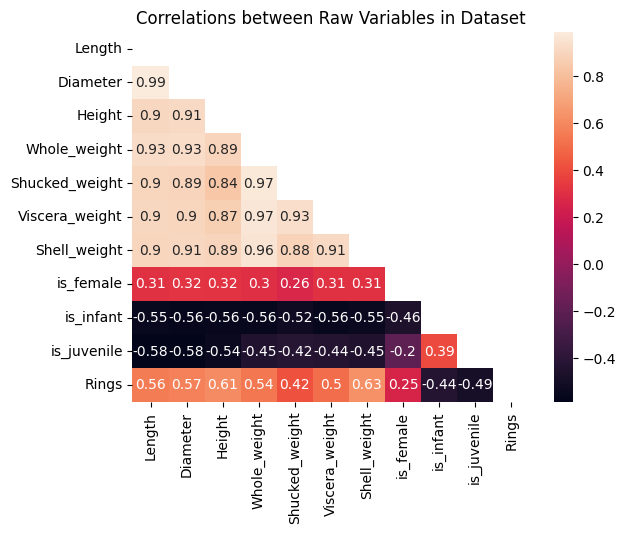

In [5]:
plt.title("Correlations between Raw Variables in Dataset")

corr_df = transformed_df.drop(columns=['const']).corr()
# Create a mask of only the upper triangle, to simplify the heatmap
matrix = np.triu(corr_df)
sns.heatmap(corr_df, annot=True, mask=matrix)
plt.savefig(os.path.join(plots_dir, 'heat_map.png'), bbox_inches = 'tight')

## Heatmap Observations
The heat map above clearly shows all the variables are positively correlated, and most are highly correlated with each other and then less, but still reasonably correlated, with the target variable, Rings.

In particular the three weight variables are nearly perfectly correlated, showing at minimum a correlation coefficient of 0.96. Similarly the Length and Diameter variables are redundant with a correlation of 0.99, and Height likely as well with correlations of 0.9 and 0.91 with those variables.

Given that the Sex and Infant variables are binary variables, measuring a correlation between them and other variables is somewhat questionable, but the results still give us some kind of expectation of the relationship we can expect between those classes and the other variables. By making the Sex_binary column NA when the infant column is true, we narrow it down to only male and female results and see a fairly weak correlation with rings. Infants, naturally, are much younger than the average abalone.

### Comparison of Two Most Correlated Variables with Rings in Abalone Dataset

Based on the heat map, the two variables with the strongest absolute correlation with the ring count are the shell weight (correlation of 0.65) and the height of the abalone (correlation of 0.61). Although many other variables are similarly close and the correlations between these variables is also high.

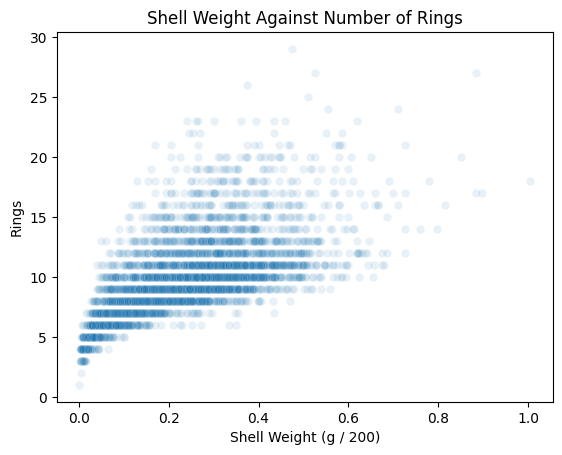

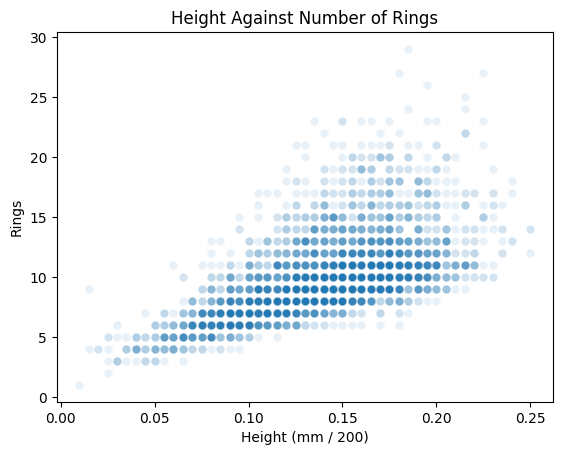

In [6]:
plt.figure(figsize=std_plot_size)
plt.title('Shell Weight Against Number of Rings')
sns.scatterplot(x='Shell_weight', y='Rings', data=transformed_df, alpha = 0.1)
plt.xlabel('Shell Weight (g / 200)')
plt.savefig(os.path.join(plots_dir, 'shell_weight_against_rings.png'), bbox_inches = 'tight')

plt.figure(figsize=std_plot_size)
plt.title('Height Against Number of Rings')
sns.scatterplot(x='Height', y='Rings', data=transformed_df, alpha = 0.1)
plt.xlabel('Height (mm / 200)')
plt.savefig(os.path.join(plots_dir, 'height_against_rings.png'), bbox_inches = 'tight')

### Observations
* Rings and height are measured in discrete increments which make it harder to assess density in above plots
* Infant class can clearly be split out, in bottom left for obvious reasons and appears to have less variability
* Size of residual seems correlated with rings which makes sense (more differences as they age) but indicates we are missing factors

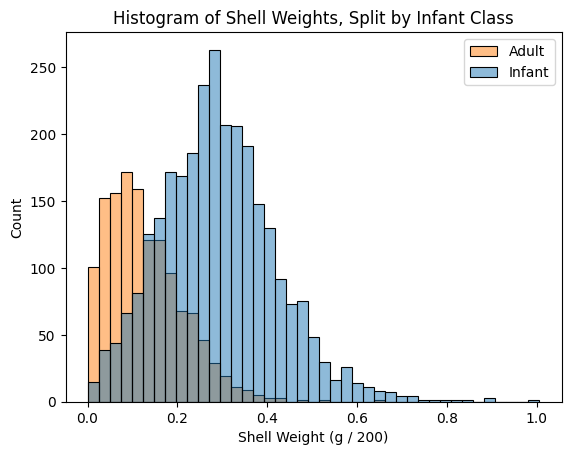

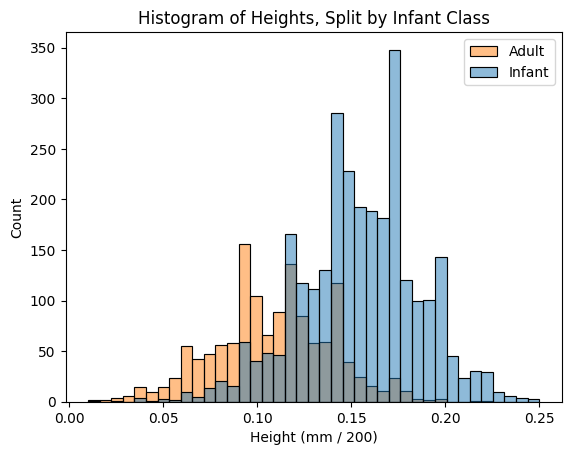

In [7]:
infant_bin_text_labels = ['Adult', 'Infant']
juvenile_bin_text_labels = ['Adult (7+ Rings)', 'Juvenile (<7 Rings)']

plt.figure(figsize=std_plot_size)
plt.title('Histogram of Shell Weights, Split by Infant Class')
sns.histplot(data=transformed_df, x='Shell_weight', hue='is_infant')
plt.xlabel('Shell Weight (g / 200)')
plt.legend(title='', loc='upper right', labels=infant_bin_text_labels)
plt.savefig(os.path.join(plots_dir, 'shell_weights_histogram.png'), bbox_inches = 'tight')

plt.figure(figsize=std_plot_size)
plt.title('Histogram of Heights, Split by Infant Class')
sns.histplot(data=transformed_df, x='Height', hue='is_infant')
plt.xlabel('Height (mm / 200)')
plt.legend(title='', loc='upper right', labels=infant_bin_text_labels)
plt.savefig(os.path.join(plots_dir, 'heights_histogram.png'), bbox_inches = 'tight')

### Observations
* Separate classes are quite close to normal after transformations
* There appears to be significant overlap in age between infants and adults
* Tails very close to 0 which is concerning (Height untransformed)
* Class imbalance for logistic regression (1342 vs 2843), more than 2:1

In [8]:
norm_exp_results = {
    'normed_RMSE': [], 'normed_r2': [], 'normed_auroc': [], 'normed_accuracy': [],
    'raw_RMSE': [], 'raw_r2': [], 'raw_auroc': [], 'raw_accuracy': []
}

for ii in range(num_exp):

    curr_seed += 1

    ### Linear Regression Experiments
    # Raw
    train_df, test_df = train_test_split(transformed_df, test_size=test_perc, random_state=curr_seed)
    lin_reg = sm.OLS(exog=train_df.drop(columns=['Rings', 'is_juvenile']), endog=train_df['Rings'], hasconst=True).fit()
    ring_cts_pred = lin_reg.predict(test_df.drop(columns=['Rings', 'is_juvenile']))
    lin_resids = test_df.Rings - ring_cts_pred

    norm_exp_results['raw_RMSE'].append(sklearn.metrics.root_mean_squared_error(test_df['Rings'], ring_cts_pred))
    norm_exp_results['raw_r2'].append(sklearn.metrics.r2_score(test_df['Rings'], ring_cts_pred))
    
    # Normalised
    ln_exog_scaler = MinMaxScaler()
    ln_endo_scaler = MinMaxScaler()

    X_train_lin = ln_exog_scaler.fit_transform(train_df.drop(columns=['Rings', 'is_juvenile']))
    X_test_lin = ln_exog_scaler.transform(test_df.drop(columns=['Rings', 'is_juvenile']))
    Y_train_lin = ln_endo_scaler.fit_transform(train_df[['Rings']])
    Y_test_lin = ln_endo_scaler.transform(test_df[['Rings']])

    norm_lin_reg = sm.OLS(exog=X_train_lin, endog=Y_train_lin).fit()
    norm_ring_cts_pred = norm_lin_reg.predict(X_test_lin)
    unts_norm_ring_cts_pred = ln_endo_scaler.inverse_transform(norm_ring_cts_pred.reshape(-1, 1))

    norm_exp_results['normed_RMSE'].append(sklearn.metrics.root_mean_squared_error(test_df['Rings'], unts_norm_ring_cts_pred))
    norm_exp_results['normed_r2'].append(sklearn.metrics.r2_score(test_df['Rings'], unts_norm_ring_cts_pred))

    ### Logistic Regression Experiments
    # Raw

    smote = SMOTE(random_state=curr_seed)

    # Re-split data with stratification for Logistic regression to ensure there is sufficient representation of Juveniles in the test data
    train_df, test_df = train_test_split(transformed_df.drop(columns=['Rings', 'const']), test_size=test_perc, random_state=curr_seed, stratify=transformed_df['is_juvenile'])

    X_train_log = train_df.drop(columns=['is_juvenile'])
    X_test_log = test_df.drop(columns=['is_juvenile'])
    Y_train_log, Y_test_log = train_df['is_juvenile'].astype(bool), test_df['is_juvenile'].astype(bool)
    all_var_test_set = np.empty(Y_test_log.shape)
    all_var_test_set[:] = Y_test_log[:]

    X_train_log_res, Y_train_log_res = smote.fit_resample(X_train_log, Y_train_log)

    log_reg = sm.Logit(exog=X_train_log_res, endog=Y_train_log_res).fit(disp=0)

    ring_class_pred_probs = log_reg.predict(X_test_log)
    ring_class_pred = ring_class_pred_probs > 0.5
    norm_exp_results['raw_accuracy'].append(sklearn.metrics.accuracy_score(test_df['is_juvenile'].astype(bool), ring_class_pred))
    norm_exp_results['raw_auroc'].append(sklearn.metrics.roc_auc_score(test_df['is_juvenile'].astype(bool), ring_class_pred_probs))

    # Normalised
    lg_exog_scaler = MinMaxScaler()

    X_train_log = lg_exog_scaler.fit_transform(train_df.drop(columns=['is_juvenile']))
    X_test_log = lg_exog_scaler.transform(test_df.drop(columns=['is_juvenile']))
    Y_train_log, Y_test_log = train_df['is_juvenile'].astype(bool), test_df['is_juvenile'].astype(bool)

    X_train_log_res, Y_train_log_res = smote.fit_resample(X_train_log, Y_train_log)

    log_reg = sm.Logit(exog=X_train_log_res, endog=Y_train_log_res).fit(disp=0)
    norm_ring_class_pred_probs = log_reg.predict(X_test_log)
    norm_ring_class_pred = norm_ring_class_pred_probs > 0.5
    norm_exp_results['normed_accuracy'].append(sklearn.metrics.accuracy_score(Y_test_log, norm_ring_class_pred))
    norm_exp_results['normed_auroc'].append(sklearn.metrics.roc_auc_score(Y_test_log, norm_ring_class_pred_probs))

In [ ]:
normed_exp_results_df = pd.DataFrame(norm_exp_results)
norm_means_df = pd.DataFrame(normed_exp_results_df.mean().round(4), columns = ['Score'])
norm_means_df['Scaling'] = ['None'] * 4 + ['Normalisation'] * 4
norm_means_df['Metric'] = ['RMSE', 'R2', 'AUROC', 'Accuracy'] * 2

norm_means_df = norm_means_df.reset_index(drop=True)

norm_means_df.pivot(values='Score', index='Scaling', columns=['Metric'])

Metric,AUROC,Accuracy,R2,RMSE
Scaling,,,,
None,0.9493,0.8705,0.5208,2.2329
Normalisation,0.9523,0.8694,0.5398,2.1879


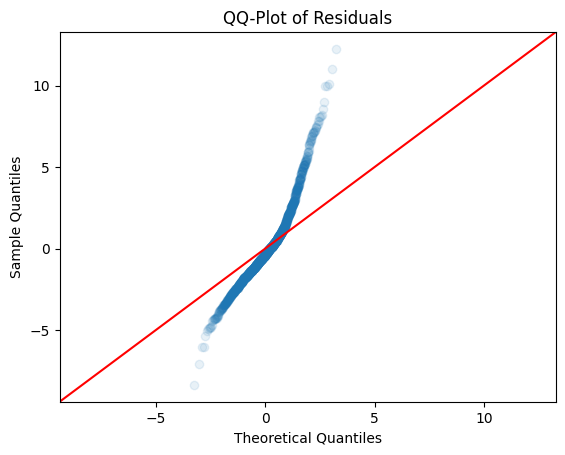

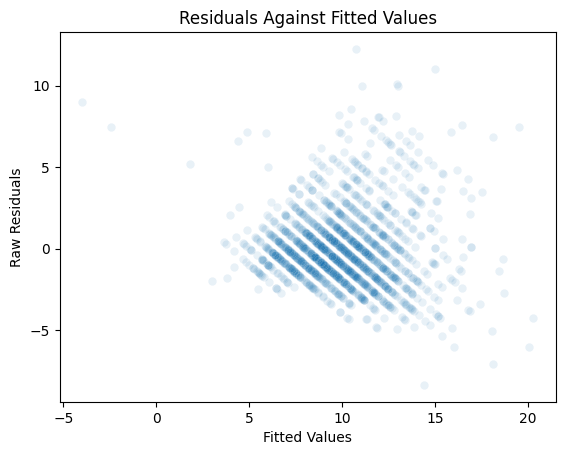

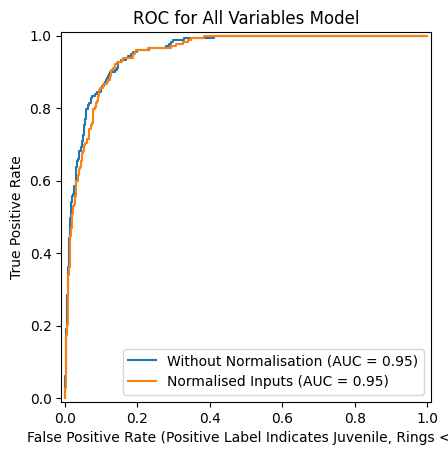

In [10]:
fig, ax = plt.subplots(figsize=std_plot_size)
plt.title("QQ-Plot of Residuals")
sm.qqplot(lin_resids, line='45', alpha=0.1, ax=ax)
plt.savefig(os.path.join(plots_dir, 'qq_plot.png'), bbox_inches = 'tight')

fig, ax = plt.subplots(figsize=std_plot_size)
plt.title("Residuals Against Fitted Values")
sns.scatterplot(x = ring_cts_pred, y = lin_resids, alpha=0.1)
plt.xlabel('Fitted Values')
plt.ylabel('Raw Residuals')
plt.savefig(os.path.join(plots_dir, 'residuals_against_fitted.png'), bbox_inches = 'tight')

fig, ax = plt.subplots()
sklearn.metrics.RocCurveDisplay.from_predictions(test_df['is_juvenile'].astype(bool), ring_class_pred_probs, name='Without Normalisation', ax=ax)
plt.title('ROC for All Variables Model')

sklearn.metrics.RocCurveDisplay.from_predictions(Y_test_log, norm_ring_class_pred_probs, name='Normalised Inputs', ax=ax)
plt.xlabel('False Positive Rate (Positive Label Indicates Juvenile, Rings <7)')
plt.ylabel('True Positive Rate')
plt.savefig(os.path.join(plots_dir, 'roc_curve_normalisation_effect_comparison.png'), bbox_inches = 'tight')

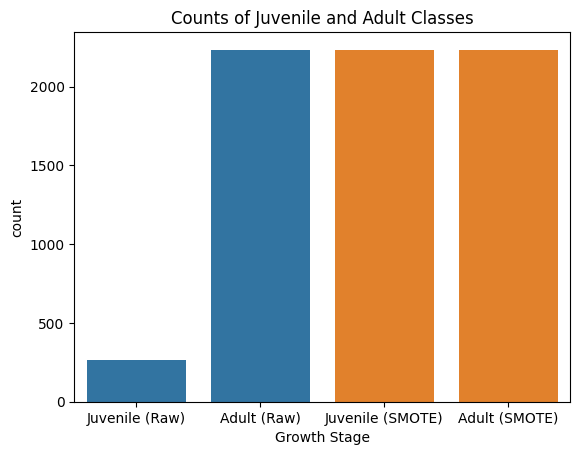

In [11]:
sns.categorical.countplot(pd.DataFrame({'Growth Stage': np.where(Y_train_log, 'Juvenile (Raw)', 'Adult (Raw)')}), x = 'Growth Stage')
sns.categorical.countplot(pd.DataFrame({'Growth Stage': np.where(Y_train_log_res, 'Juvenile (SMOTE)', 'Adult (SMOTE)')}), x = 'Growth Stage')

plt.title('Counts of Juvenile and Adult Classes')
plt.xlabel('Growth Stage')
plt.savefig(os.path.join(plots_dir, 'growth_stage_count_plot.png'), bbox_inches = 'tight')

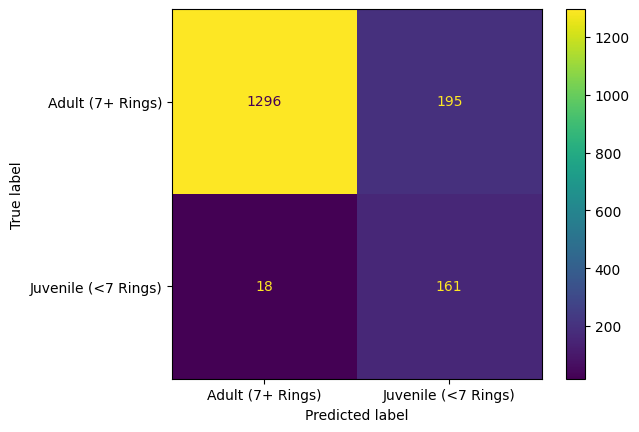

In [12]:
confusion_mat = sklearn.metrics.confusion_matrix(Y_test_log, ring_class_pred, labels=[False, True])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=juvenile_bin_text_labels)
disp.plot()
plt.savefig(os.path.join(plots_dir, 'confusion_matrix.png'), bbox_inches = 'tight')

### Comments on Normalisation
Appears to have a slight negative impact on results

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     876.3
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          4.10e-289
Time:                        14:03:46   Log-Likelihood:                -5827.1
No. Observations:                2503   AIC:                         1.166e+04
Df Residuals:                    2500   BIC:                         1.168e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Height          19.5988      2.843      6.894   

Text(0, 0.5, 'Residuals')

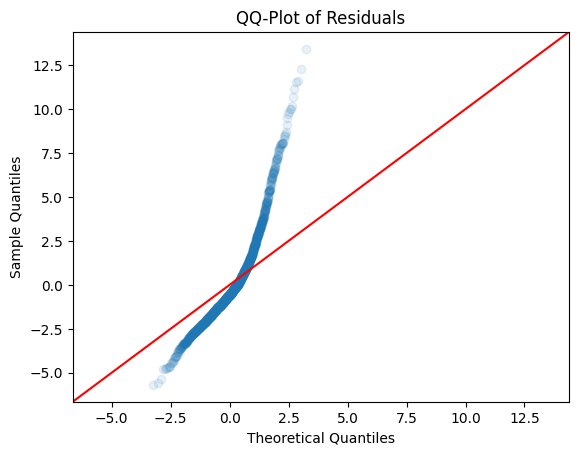

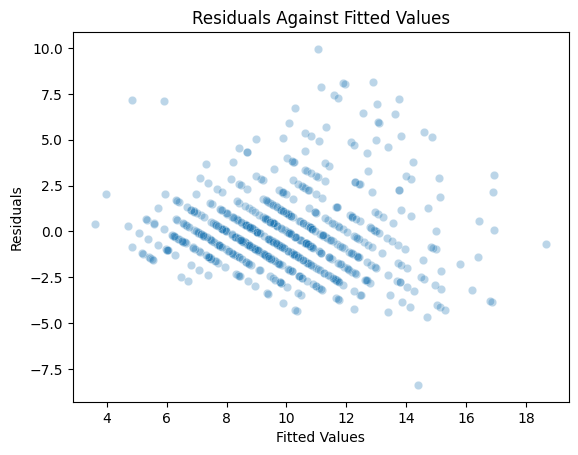

In [13]:
mean_r2 = []
mean_rmse = []

for ii in range(num_exp):
    curr_seed += 1

    train_df, test_df = train_test_split(transformed_df[['Height', 'Shell_weight', 'Rings', 'is_juvenile', 'const']], test_size=test_perc, random_state=curr_seed)
    two_var_lin_model = sm.OLS(exog=train_df.drop(columns=['Rings', 'is_juvenile']), endog=train_df['Rings']).fit()
    two_var_ring_cts_pred = two_var_lin_model.predict(test_df.drop(columns=['Rings', 'is_juvenile']))
    two_var_resids = test_df['Rings'] - two_var_ring_cts_pred

    mean_rmse.append(sklearn.metrics.root_mean_squared_error(test_df['Rings'], two_var_ring_cts_pred))
    mean_r2.append(sklearn.metrics.r2_score(test_df['Rings'], two_var_ring_cts_pred))

print(two_var_lin_model.summary())
print(f'2 Var R2: {np.mean(mean_r2)}')
print(f'2 Var RMSE: {np.mean(mean_rmse)}')

fig, ax = plt.subplots(figsize=std_plot_size)
plt.title("QQ-Plot of Residuals")
sm.qqplot(two_var_resids, line='45', alpha=0.1, ax=ax)

fig, ax = plt.subplots(figsize=std_plot_size)
plt.title("Residuals Against Fitted Values")
sns.scatterplot(x = ring_cts_pred, y = test_df.Rings - ring_cts_pred, alpha = 0.3)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

                           Logit Regression Results                           
Dep. Variable:            is_juvenile   No. Observations:                 4470
Model:                          Logit   Df Residuals:                     4468
Method:                           MLE   Df Model:                            1
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:                  0.5656
Time:                        14:03:46   Log-Likelihood:                -1346.0
converged:                       True   LL-Null:                       -3098.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Height          58.0570      1.762     32.951      0.000      54.604      61.510
Shell_weight   -54.0579      1.702    -31.768      0.000     -57.393     -50.723

Possibly complete quasi-separation: A fract

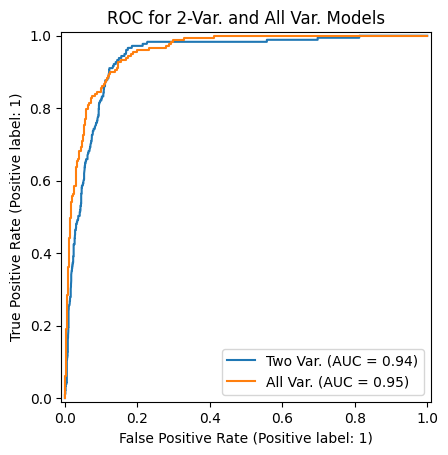

In [14]:
mean_auroc = []
mean_accuracy = []

for ii in range(num_exp):
    curr_seed += 1

    train_df, test_df = train_test_split(transformed_df[['Height', 'Shell_weight', 'is_juvenile']], test_size=test_perc, random_state=curr_seed, stratify=transformed_df['is_juvenile'])
    
    smote = SMOTE(random_state=curr_seed)

    X_train_log = train_df.drop(columns=['is_juvenile'])
    X_test_log = test_df.drop(columns=['is_juvenile'])
    Y_train_log, Y_test_log = train_df['is_juvenile'].astype(bool), test_df['is_juvenile'].astype(bool)

    X_train_log_res, Y_train_log_res = smote.fit_resample(X_train_log, Y_train_log)

    log_reg = sm.Logit(exog=X_train_log_res, endog=Y_train_log_res).fit(disp=0)

    two_var_ring_class_pred_probs = log_reg.predict(X_test_log)
    two_var_ring_class_pred = two_var_ring_class_pred_probs > 0.5
    mean_accuracy.append(sklearn.metrics.accuracy_score(Y_test_log, two_var_ring_class_pred))
    mean_auroc.append(sklearn.metrics.roc_auc_score(Y_test_log, two_var_ring_class_pred_probs))

print(log_reg.summary())
print(f'2 Var AUROC: {np.mean(mean_auroc)}')
print(f'2 Var Accuracy: {np.mean(mean_accuracy)}')

fig, ax = plt.subplots()
sklearn.metrics.RocCurveDisplay.from_predictions(Y_test_log, two_var_ring_class_pred_probs, ax=ax, name = 'Two Var.')
sklearn.metrics.RocCurveDisplay.from_predictions(all_var_test_set, ring_class_pred_probs, ax=ax, name = 'All Var.')
plt.title('ROC for 2-Var. and All Var. Models')
plt.savefig(os.path.join(plots_dir, 'roc_two_var_vs_all_var.png'), bbox_inches = 'tight')

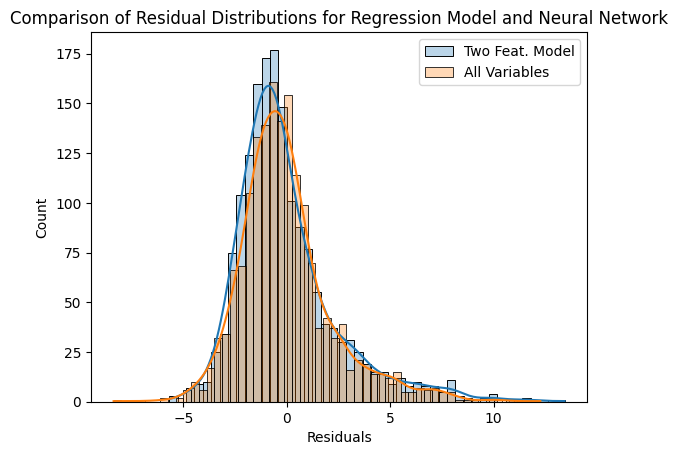

In [15]:
sns.histplot(two_var_resids, kde=True, alpha=0.3, label = "Two Feat. Model")
sns.histplot(lin_resids, kde=True, alpha=0.3, label = "All Variables")
plt.legend()
plt.title('Comparison of Residual Distributions for Regression Model and Neural Network')
plt.xlabel('Residuals')
plt.savefig(os.path.join(plots_dir, 'nn_vs_lin_reg_residuals_comparison.png'), bbox_inches = 'tight')

In [16]:
# TODO: add simple comparisons of 2 variable and all variable models
#   * metrics
#   * ROC of both on sample plot
#   * Histogram of the residuals of both?

## Neural Network

### Basic Hyperparameter Experimentation
* Experimented with basic single layer nn to find suitable learning rate testing values from 1e-8 to 1e+1
* Stuck with default batch size given small model and small sample size (training time not an issue)
* Attempted two layers with different ratios of neurons and saw results decrease
* Increased and decreased neurons in first layer as ratios and saw 1:1 neurons converged faster but performance was slightly lower, in the interests of parsimony stuck with half as many neurons as features
* Implemented a basic early stop, which reverted to best weights and had a patience of 25, checking based on val_loss to avoid overfitting to the training set itself. Didn't need to choose number of epochs, and epochs ran give an indication of appropriateness of learning rate
* Explored trade-off of StandardScaler (had to use global_clipnorm=1 to deal with exploding gradients, regulariser wasn't effective) vs MinMaxScaler 

In [17]:
def create_nn_model(features, summary=False, lr=0.1):
    keras.api.backend.clear_session()
    batch_size = 32

    model = keras.Sequential(
        [
            keras.layers.Input(shape=(features, ), batch_size=batch_size),
            keras.layers.Dense(features // 2, activation="elu"),
            keras.layers.Dense(1),
        ]
    )

    if summary:
        model.summary()

    model.compile(
        loss=keras.losses.mean_squared_error,
        optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.6), #, global_clipnorm=1
        metrics=[keras.metrics.R2Score, keras.metrics.RootMeanSquaredError],
    )
    
    return model
model = create_nn_model(features=X_train_lin.shape[1], summary=True)

I0000 00:00:1728529429.625225 1366393 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728529429.647784 1366393 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728529429.647829 1366393 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728529429.650756 1366393 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728529429.650870 1366393 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 5)                │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
curr_seed += 1

learning_rate = 0.1
val_split = 0.2
patience = 25

train_df, test_df = train_test_split(transformed_df.drop(columns=['is_juvenile', 'const']), test_size=test_perc, random_state=curr_seed)

nn_exog_scaler = StandardScaler()
nn_endo_scaler = StandardScaler()

X_train_nn = nn_exog_scaler.fit_transform(train_df.drop(columns=['Rings']))
X_test_nn = nn_exog_scaler.transform(test_df.drop(columns=['Rings']))
Y_train_nn = nn_endo_scaler.fit_transform(train_df[['Rings']])
Y_test_nn = nn_endo_scaler.transform(test_df[['Rings']])

model = create_nn_model(features=X_train_nn.shape[1], lr=learning_rate)
early_stop = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
nan_stop = keras.callbacks.TerminateOnNaN()
model_results = model.fit(x=X_train_nn, y=Y_train_nn, epochs=1000, validation_split=val_split, callbacks=[early_stop, nan_stop], verbose=0)

I0000 00:00:1728529431.081801 1366668 service.cc:146] XLA service 0x7f7f28009790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728529431.081836 1366668 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-10 14:03:51.103590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 14:03:51.127456: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1728529431.528724 1366668 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [19]:
best_epoch = early_stop.best_epoch
print(model_results.history['val_r2_score'][best_epoch])
print(model_results.history['r2_score'][best_epoch])

0.608553409576416
0.5563381314277649


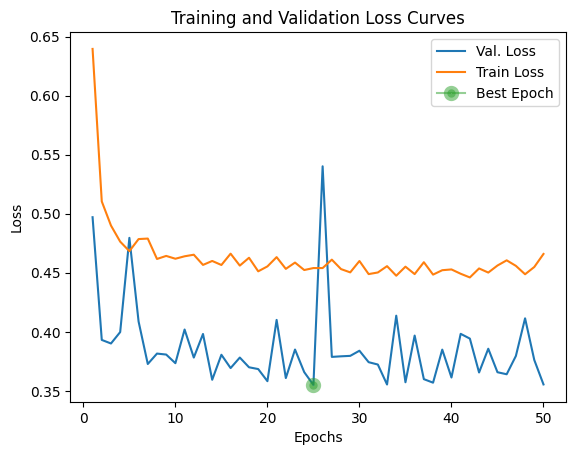

In [20]:
epochs_run = model_results.epoch[-1] + 1
best_epoch = early_stop.best_epoch

fig, ax = plt.subplots(figsize=std_plot_size)
plt.plot(np.arange(epochs_run) + 1, model_results.history['val_loss'], label='Val. Loss')
plt.plot(np.arange(epochs_run) + 1, model_results.history['loss'], label='Train Loss')
plt.plot(best_epoch + 1, [model_results.history['val_loss'][best_epoch]], 'o-', markeredgewidth=5, alpha=0.5, label='Best Epoch')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig(os.path.join(plots_dir, 'nn_train_loss_trend.png'), bbox_inches = 'tight')

In [21]:
nn_pred_vals = model.predict(X_test_nn)
unscaled_nn_pred_vals = nn_endo_scaler.inverse_transform(nn_pred_vals).reshape(-1)

print(sklearn.metrics.r2_score(test_df['Rings'], unscaled_nn_pred_vals))
print(sklearn.metrics.root_mean_squared_error(test_df['Rings'], unscaled_nn_pred_vals))

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0.5608960390090942
2.109519117067241


### Neural Network vs Linear Model Comparison
* Compare R^2 results
* Compare KDE plots
* Conclude there is little difference but Lin. Model has more obvious explainability, fewer parameters etc

Further improvement:
* Clearly there is some kind of variable missing which helps to separate older abalone from each other
* Further hyperparameter tuning will likely introduce some but minor performance gains

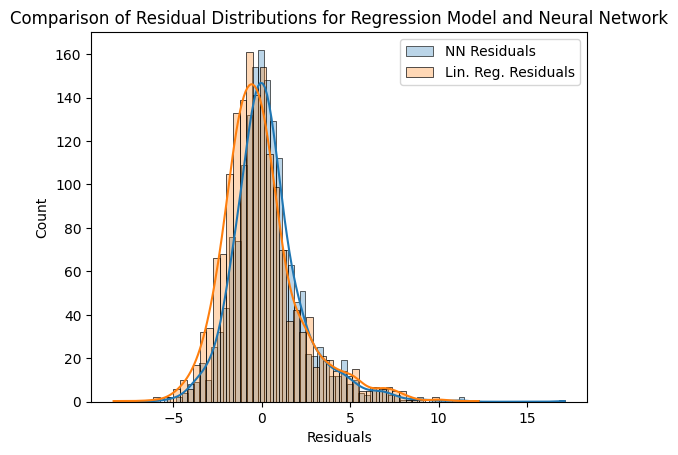

In [22]:
sns.histplot(test_df.Rings - unscaled_nn_pred_vals, kde=True, alpha=0.3, label = "NN Residuals")
sns.histplot(lin_resids, kde=True, alpha=0.3, label = "Lin. Reg. Residuals")
plt.legend()
plt.title('Comparison of Residual Distributions for Regression Model and Neural Network')
plt.xlabel('Residuals')
plt.savefig(os.path.join(plots_dir, 'nn_vs_lin_reg_residuals_comparison.png'), bbox_inches = 'tight')

In [23]:
results = {
    'lin_reg_train_rmse': [], 'nn_train_rmse': [], 'lin_reg_train_r2': [],  'nn_train_r2': [],
    'lin_reg_test_rmse': [], 'nn_test_rmse': [], 'lin_reg_test_r2': [], 'nn_test_r2': [],
    'nn_val_r2': [], 'epochs_ran': [], 'model_delta': []
}

for ii in range(num_exp):
    logging.info(f'Experiment: {ii}')
    curr_seed += 1

    train_df, test_df = train_test_split(transformed_df.drop(columns=['is_juvenile']), test_size=test_perc, random_state=curr_seed)

    ### Neural Net Experiment
    nn_exog_scaler = MinMaxScaler()
    nn_endo_scaler = MinMaxScaler()

    X_train_nn = nn_exog_scaler.fit_transform(train_df.drop(columns=['Rings']))
    X_test_nn = nn_exog_scaler.transform(test_df.drop(columns=['Rings']))
    Y_train_nn = nn_endo_scaler.fit_transform(train_df[['Rings']])
    Y_test_nn = nn_endo_scaler.transform(test_df[['Rings']])
    
    nn = create_nn_model(features=X_train_nn.shape[1], lr=learning_rate)
    early_stop = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    model_results = nn.fit(x=X_train_nn, y=Y_train_nn, epochs=1000, validation_split=val_split, callbacks=[early_stop], verbose=0)
    
    nn_train_preds = nn.predict(x=X_train_nn, verbose=0)
    unscaled_nn_train_pred = nn_endo_scaler.inverse_transform(nn_train_preds)
    results['nn_train_rmse'].append(sklearn.metrics.root_mean_squared_error(train_df['Rings'], unscaled_nn_train_pred))
    
    results['nn_val_r2'].append(model_results.history['val_r2_score'][early_stop.best_epoch])
    results['nn_train_r2'].append(model_results.history['r2_score'][early_stop.best_epoch])
    
    # Predict test set
    nn_pred_vals = nn.predict(X_test_nn, verbose=0)
    unscaled_nn_pred_vals = nn_endo_scaler.inverse_transform(nn_pred_vals).reshape(-1)

    results['nn_test_r2'].append(sklearn.metrics.r2_score(test_df['Rings'], unscaled_nn_pred_vals))
    results['nn_test_rmse'].append(sklearn.metrics.root_mean_squared_error(test_df['Rings'], unscaled_nn_pred_vals))
    
    ### Linear Regression
    lin_reg = sm.OLS(exog=train_df.drop(columns=['Rings']), endog=train_df['Rings'], hasconst=True).fit()
    lin_reg_train_pred = lin_reg.predict()
    lin_reg_test_pred = lin_reg.predict(test_df.drop(columns=['Rings']))

    results['lin_reg_test_r2'].append(sklearn.metrics.r2_score(test_df['Rings'], lin_reg_test_pred))
    results['lin_reg_test_rmse'].append(sklearn.metrics.root_mean_squared_error(test_df['Rings'], lin_reg_test_pred))
    results['lin_reg_train_r2'].append(sklearn.metrics.r2_score(train_df['Rings'], lin_reg_train_pred))
    results['lin_reg_train_rmse'].append(sklearn.metrics.root_mean_squared_error(train_df['Rings'], lin_reg_train_pred))
    
    results['epochs_ran'].append(model_results.epoch[-1] + 1)
    results['model_delta'].append(results['nn_test_r2'][-1] - results['lin_reg_test_r2'][-1])
    logging.info(f'Epochs Ran: {results["epochs_ran"][-1]}, Model Delta: {results["model_delta"][-1]:.4f}')

INFO - 2024-10-10 14:04:01,799 - Experiment: 0
INFO - 2024-10-10 14:04:21,828 - Epochs Ran: 106, Model Delta: 0.0071
INFO - 2024-10-10 14:04:21,830 - Experiment: 1
INFO - 2024-10-10 14:05:11,644 - Epochs Ran: 301, Model Delta: 0.0198
INFO - 2024-10-10 14:05:11,647 - Experiment: 2
INFO - 2024-10-10 14:05:26,747 - Epochs Ran: 82, Model Delta: -0.0145
INFO - 2024-10-10 14:05:26,749 - Experiment: 3
INFO - 2024-10-10 14:05:44,305 - Epochs Ran: 97, Model Delta: -0.0075
INFO - 2024-10-10 14:05:44,306 - Experiment: 4
INFO - 2024-10-10 14:05:59,349 - Epochs Ran: 81, Model Delta: -0.0119
INFO - 2024-10-10 14:05:59,350 - Experiment: 5
INFO - 2024-10-10 14:06:34,538 - Epochs Ran: 210, Model Delta: 0.0124
INFO - 2024-10-10 14:06:34,539 - Experiment: 6
INFO - 2024-10-10 14:06:54,087 - Epochs Ran: 114, Model Delta: 0.0004
INFO - 2024-10-10 14:06:54,087 - Experiment: 7
INFO - 2024-10-10 14:07:11,015 - Epochs Ran: 94, Model Delta: 0.0004
INFO - 2024-10-10 14:07:11,016 - Experiment: 8
INFO - 2024-10-10 

In [24]:
def clean_up_dataframe(df, eval_struct_df, col):
    cleaned_df = eval_struct_df.join(df.iloc[:-3].reset_index(drop=True))
    output_df = cleaned_df.pivot(values=col, columns='Model', index=['Dataset', 'Metric']).reset_index()
    output_df.columns.names = [None, None]
    
    return output_df

In [32]:
combinations = product(['Train', 'Test'], ['RMSE', 'R2'], ['Linear Regression', 'Neural Network'])
eval_struct_df = pd.DataFrame(list(combinations), columns=['Dataset', 'Metric', 'Model'])
results_df = pd.DataFrame(results)

means_df = pd.DataFrame(results_df.mean().round(3), columns=['Mean Scores'])
stdevs_df = pd.DataFrame(results_df.std().round(4), columns=['Std. Deviation of Scores'])
combined_df = pd.concat([means_df, stdevs_df], axis=1)

combined_df

,Mean Scores,Std. Deviation of Scores
lin_reg_train_rmse,2.174,0.0285
nn_train_rmse,2.157,0.0380
lin_reg_train_r2,0.544,0.0085
nn_train_r2,0.535,0.0156
lin_reg_test_rmse,2.188,0.0422
nn_test_rmse,2.174,0.0474
lin_reg_test_r2,0.541,0.0128
nn_test_r2,0.547,0.0132
nn_val_r2,0.549,0.0315
epochs_ran,184.567,93.6198


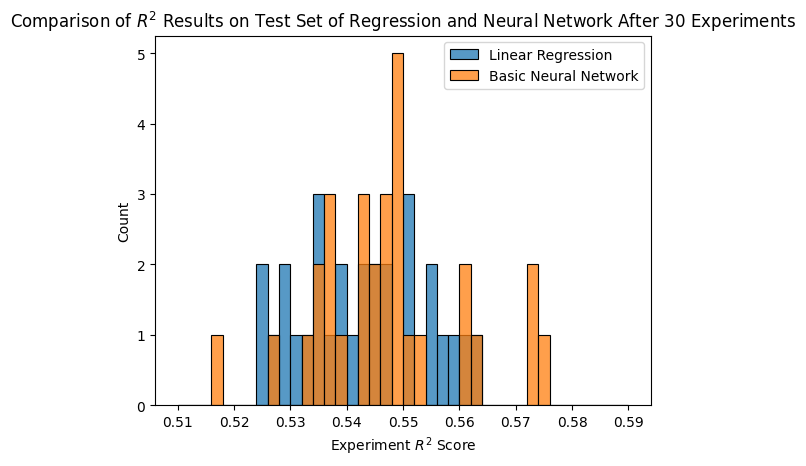

In [26]:
fig, ax = plt.subplots(figsize=std_plot_size)

sns.histplot(data=results_df, x='lin_reg_test_r2', binwidth=0.002, binrange=(0.51, 0.59), label='Linear Regression', ax=ax)
sns.histplot(data=results_df, x='nn_test_r2', binwidth=0.002, binrange=(0.51, 0.59), label='Basic Neural Network', ax=ax)
plt.xlabel('Experiment $R^2$ Score')
plt.legend()
plt.title(f'Comparison of $R^2$ Results on Test Set of Regression and Neural Network After {num_exp} Experiments')
plt.savefig(os.path.join(plots_dir, 'r2_dist_comparison'))

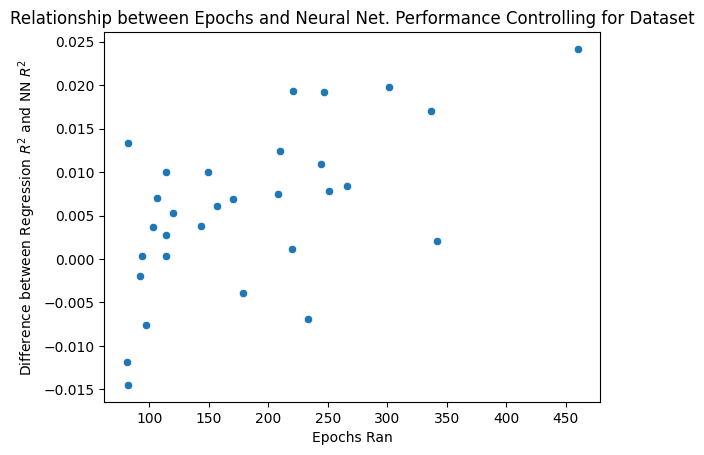

In [27]:
sns.scatterplot(data=results_df, x='epochs_ran', y='model_delta')
plt.ylabel('Difference between Regression $R^2$ and NN $R^2$')
plt.xlabel('Epochs Ran')
plt.title('Relationship between Epochs and Neural Net. Performance Controlling for Dataset')

plt.savefig(os.path.join(plots_dir, 'epochs_vs_nn_model_improvement'))